<a href="https://colab.research.google.com/github/cabluemgeek/Crude-Oil-Forecast-/blob/main/Daily_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model apploading and preprocessing**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Concatenate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping




In [ ]:
tf.random.set_seed(42)

In [ ]:
data = pd.read_csv('/Data daily (1).csv', sep=';')

In [ ]:
data['GPR'] = data['GPR'].str.replace(',', '.')
data['USD/DZD'] = data['USD/DZD'].str.replace(',', '.')

In [ ]:
data.drop('Unnamed: 4', axis=1, inplace=True)
data.drop('Unnamed: 5', axis=1, inplace=True)
data.drop('Unnamed: 6', axis=1, inplace=True)
data.drop('Unnamed: 7', axis=1, inplace=True)

In [ ]:
data["GPR"] = data["GPR"].replace(["1.045.60"], "1045.60")

In [ ]:
data['DAY'] = pd.to_datetime(data['DAY'], format='%d/%m/%Y')
data['DAY'] = pd.to_datetime(data['DAY'])

In [ ]:
data.set_index('DAY', inplace=True)

In [ ]:
data['USD/DZD'] = data['USD/DZD'].astype(float)
data['GPR'] = data['GPR'].astype(float)
data

,USD/DZD,GPR,PRICE
DAY,,,
2000-01-01,NaN,123.08,NaN
2000-01-02,NaN,50.32,NaN
2000-01-03,69.258,101.02,NaN
2000-01-04,68.337,93.75,25.55
2000-01-05,68.017,47.57,24.91
...,...,...,...
2022-12-27,136.678,146.82,87.47
2022-12-28,137.079,151.89,86.66
2022-12-29,137.139,116.49,86.66


In [ ]:
data.isnull().sum()

,0
USD/DZD,2
GPR,0
PRICE,3


In [ ]:
data = data.fillna(method='bfill')
data

<ipython-input-14-586856764918>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill')


,USD/DZD,GPR,PRICE
DAY,,,
2000-01-01,69.258,123.08,25.55
2000-01-02,69.258,50.32,25.55
2000-01-03,69.258,101.02,25.55
2000-01-04,68.337,93.75,25.55
2000-01-05,68.017,47.57,24.91
...,...,...,...
2022-12-27,136.678,146.82,87.47
2022-12-28,137.079,151.89,86.66
2022-12-29,137.139,116.49,86.66


VISUALISE DATA

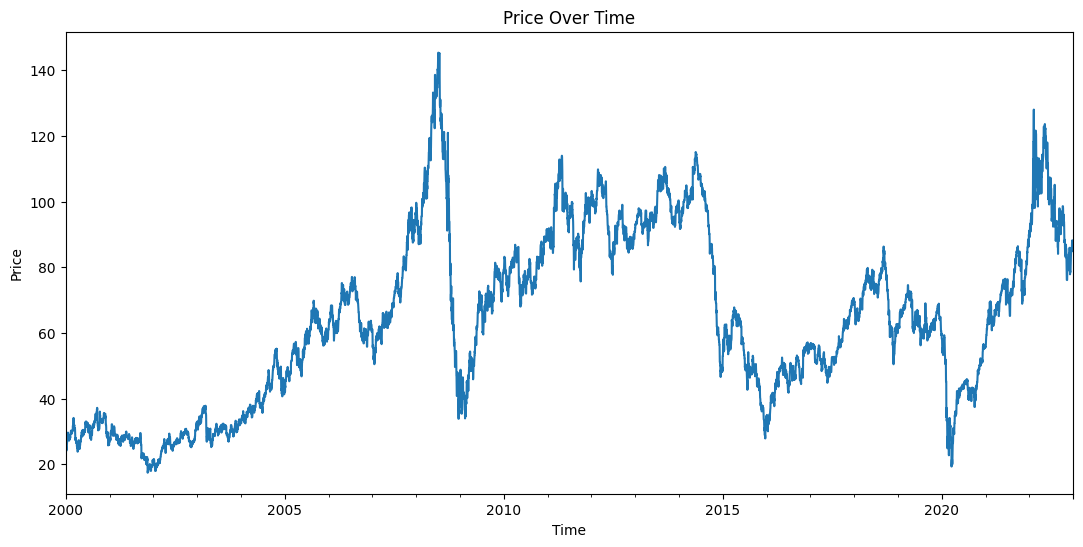

In [ ]:
#plotting price over time-frame
data['PRICE'].plot(kind='line', figsize=(13, 6))
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Price Over Time')
plt.show()

OUTLIERS

In [ ]:
# Calculate the Z-score for each data point
z_scores = np.abs((data['PRICE'] - data['PRICE'].mean()) / data['PRICE'].std())

# Identify outliers with Z-scores greater than 3 or less than -3
outliers = data[np.logical_or(z_scores > 3, z_scores < -3)]
outliers

,USD/DZD,GPR,PRICE
DAY,,,
2008-07-02,61.790,107.09,143.57
2008-07-03,62.040,83.71,145.29
2008-07-04,61.970,66.85,145.29
2008-07-05,61.970,53.93,145.29
2008-07-06,61.970,41.41,145.29
2008-07-11,61.445,99.80,145.08
2008-07-12,61.445,75.02,145.08
2008-07-13,61.445,55.72,145.08
2008-07-14,61.485,137.71,145.18


In [ ]:
# Remove outliers from the data
data = data[~data.index.isin(outliers.index)]
#print data
data

,USD/DZD,GPR,PRICE
DAY,,,
2000-01-01,69.258,123.08,25.55
2000-01-02,69.258,50.32,25.55
2000-01-03,69.258,101.02,25.55
2000-01-04,68.337,93.75,25.55
2000-01-05,68.017,47.57,24.91
...,...,...,...
2022-12-27,136.678,146.82,87.47
2022-12-28,137.079,151.89,86.66
2022-12-29,137.139,116.49,86.66


**DENOISING**

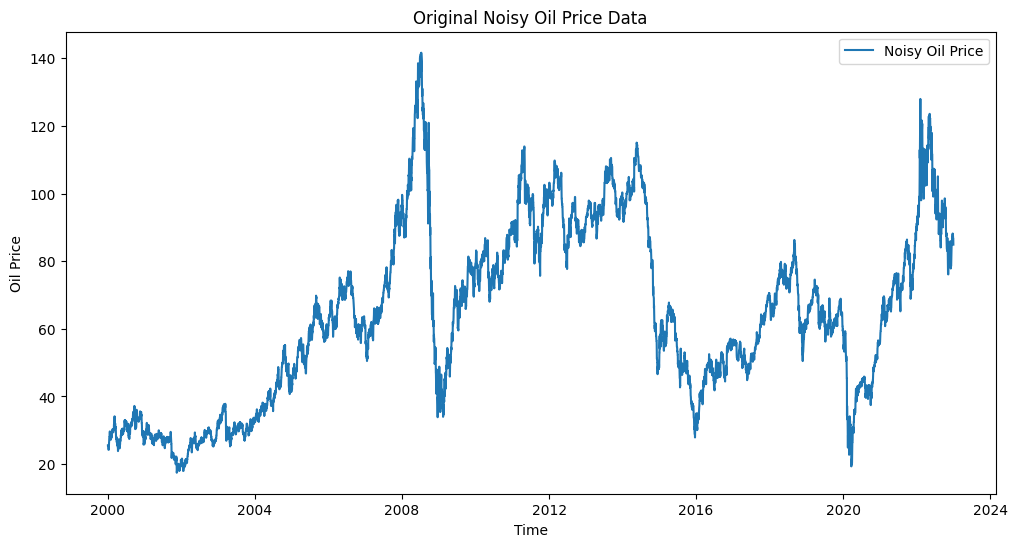

<ipython-input-18-771ddc03f19f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PRICEG'] = gaussian_filter1d(data['PRICE'], sigma=sigma)


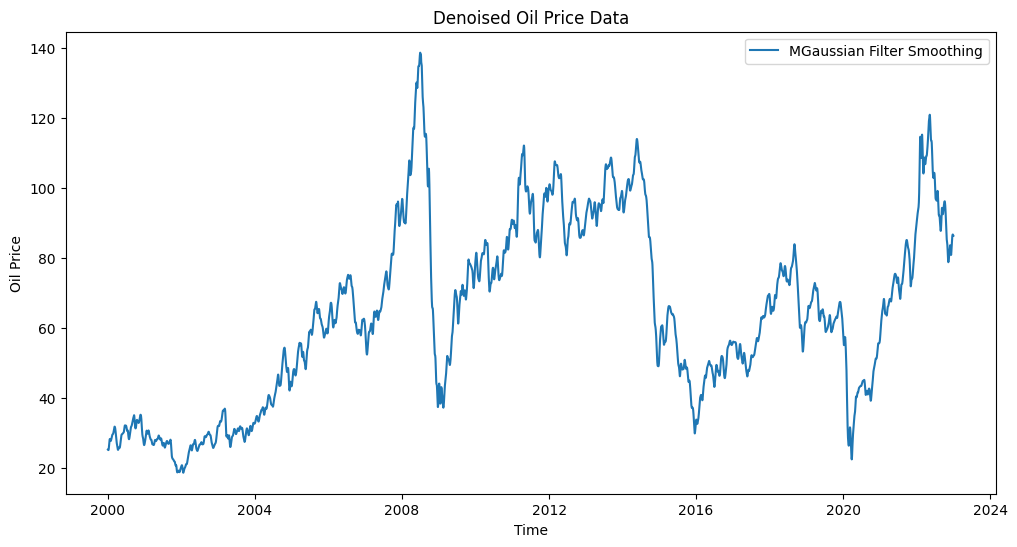

,USD/DZD,GPR,PRICE,PRICEG
DAY,,,,
2000-01-01,69.258,123.08,25.55,25.272929
2000-01-02,69.258,50.32,25.55,25.250758
2000-01-03,69.258,101.02,25.55,25.212659
2000-01-04,68.337,93.75,25.55,25.170451
2000-01-05,68.017,47.57,24.91,25.140147
...,...,...,...,...
2022-12-27,136.678,146.82,87.47,86.658100
2022-12-28,137.079,151.89,86.66,86.581204
2022-12-29,137.139,116.49,86.66,86.506870


In [ ]:
from scipy.ndimage import gaussian_filter1d

# Plot the original noisy data
plt.figure(figsize=(12, 6))
plt.plot(data['PRICE'], label='Noisy Oil Price')
plt.title('Original Noisy Oil Price Data')
plt.xlabel('Time')
plt.ylabel('Oil Price')
plt.legend()
plt.show()

# Smoothing using Gaussian Filter
sigma = 4
data['PRICEG'] = gaussian_filter1d(data['PRICE'], sigma=sigma)

# Plot the original noisy data
plt.figure(figsize=(12, 6))
plt.plot(data['PRICEG'], label='MGaussian Filter Smoothing')
plt.title('Denoised Oil Price Data')
plt.xlabel('Time')
plt.ylabel('Oil Price')
plt.legend()
plt.show()
data

In [ ]:
data['PRICE']=data['PRICEG']
data.drop('PRICEG', axis=1, inplace=True)
data

<ipython-input-19-e32970955faf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PRICE']=data['PRICEG']
<ipython-input-19-e32970955faf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('PRICEG', axis=1, inplace=True)


,USD/DZD,GPR,PRICE
DAY,,,
2000-01-01,69.258,123.08,25.272929
2000-01-02,69.258,50.32,25.250758
2000-01-03,69.258,101.02,25.212659
2000-01-04,68.337,93.75,25.170451
2000-01-05,68.017,47.57,25.140147
...,...,...,...
2022-12-27,136.678,146.82,86.658100
2022-12-28,137.079,151.89,86.581204
2022-12-29,137.139,116.49,86.506870


In [ ]:
# Calculer la matrice de corrélation
corr_matrix = data.corr()
corr_matrix

,USD/DZD,GPR,PRICE
USD/DZD,1.000000,0.006904,0.035207
GPR,0.006904,1.000000,-0.156378
PRICE,0.035207,-0.156378,1.000000


# **Data spliting**

In [ ]:
X = data.drop('PRICE', axis=1)
y = data['PRICE']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **SVR model**

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [ ]:
# Define the parameter grid
param_grid = {
    'C': [1, 10, 100, 1000],
    'gamma': [0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

In [ ]:
svr=SVR()

In [ ]:
# Perform grid search with MSE as the scoring metric
grid_search_svr = GridSearchCV(svr, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search_svr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             scoring='neg_mean_squared_error')

In [ ]:
# Get the best parameters and the corresponding model
best_params_svr = grid_search_svr.best_params_
best_model_svr = grid_search_svr.best_estimator_

In [ ]:
# Print best parameters and best score
print("Best Parameters found: ", grid_search_svr.best_params_)
print("Lowest score found: ", -grid_search_svr.best_score_)

Best Parameters found:  {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Lowest score found:  467.5556672111899


In [ ]:
# Make predictions using the best model
svr_predictions = best_model_svr.predict(X_test)
svr_results = pd.DataFrame({'actual prices': y_test, 'svr predictionds': svr_predictions})
print(svr_results)

            actual prices  svr predictionds
DAY                                        
2008-04-11     110.493356        108.230396
2014-06-15     107.373151         96.753772
2005-07-24      58.773857         73.270563
2007-11-25      95.159061         82.764840
2006-02-24      61.529147         72.949814
...                   ...               ...
2019-04-16      71.404821         64.552245
2018-05-10      76.089681         61.865942
2000-11-20      35.238472         62.680940
2003-04-30      26.063182         28.060084
2018-04-08      76.025655         64.748916

[1679 rows x 2 columns]


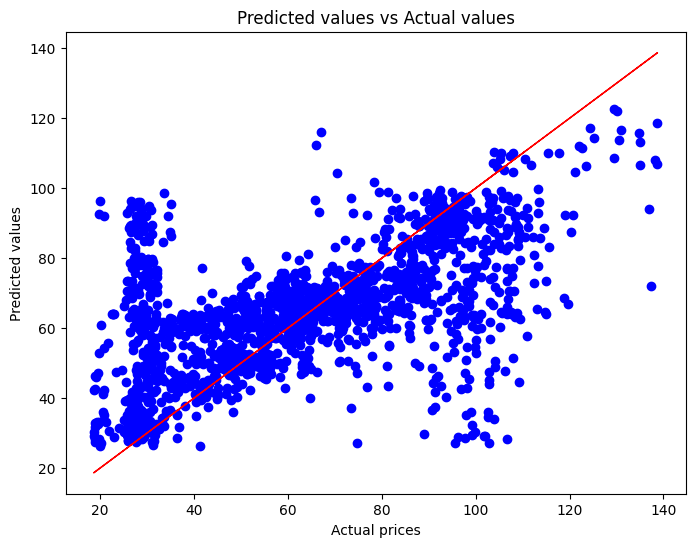

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, svr_predictions, color='blue')
plt.plot(y_test, y_test, color='red', linestyle='-', linewidth=1)
plt.xlabel('Actual prices')
plt.ylabel('Predicted values')
plt.title('Predicted values vs Actual values')
plt.show()

In [ ]:
# Calculate RMSE and R2
svr_rmse = np.sqrt(mean_squared_error(y_test, svr_predictions))
svr_r2 = r2_score(y_test, svr_predictions)
print(f"RMSE: {svr_rmse:.2f}")
print(f"R2: {svr_r2:.2f}")

RMSE: 21.69
R2: 0.33


# **Random Forest model**

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
seed=42
rf = RandomForestRegressor(random_state=seed)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
rf_predictions = rf.predict(X_test)

In [ ]:
resultsRF = pd.DataFrame({'actual prices': y_test, 'randomforest predictionds': rf_predictions})
print(resultsRF)

            actual prices  randomforest predictionds
DAY                                                 
2008-04-11     110.493356                 105.438512
2014-06-15     107.373151                  84.412191
2005-07-24      58.773857                  69.699426
2007-11-25      95.159061                  93.469943
2006-02-24      61.529147                  62.846396
...                   ...                        ...
2019-04-16      71.404821                  68.148951
2018-05-10      76.089681                  74.938583
2000-11-20      35.238472                  37.173565
2003-04-30      26.063182                  39.026556
2018-04-08      76.025655                  75.037775

[1679 rows x 2 columns]


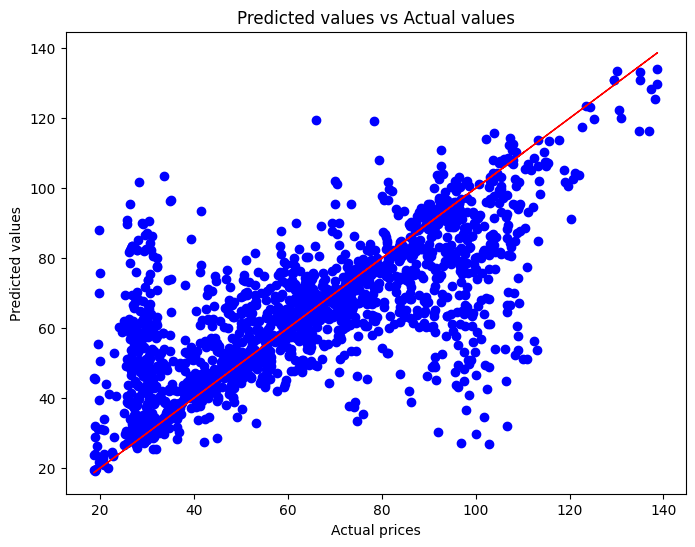

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, rf_predictions, color='blue')
plt.plot(y_test, y_test, color='red', linestyle='-', linewidth=1)
plt.xlabel('Actual prices')
plt.ylabel('Predicted values')
plt.title('Predicted values vs Actual values')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
rf_mse = mean_squared_error(y_test, rf_predictions, squared=False )
print(f"Root Mean Squared Error: {rf_mse}")

Root Mean Squared Error: 18.48484669157709


In [ ]:
rf_r2 = r2_score(y_test, rf_predictions)
print(f"R² = {rf_r2:.2f}")

R² = 0.51


# **RF**

In [ ]:
# Define the parameter grid for the Random Forest model
param_grid = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [1, 2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10]
}

In [ ]:
# Initialize the Random Forest model
rf = RandomForestRegressor()

In [ ]:
# Perform grid search to find the best parameters
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
500 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/u

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 5, 10, 15, 20],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [1, 2, 5, 10],
                         'n_estimators': [10, 50, 100, 200, 500]},
             scoring='neg_mean_squared_error')

In [ ]:
# Get the best model and its parameters
best_model_rf = grid_search.best_estimator_
best_params_rf = grid_search.best_params_
# Print best parameters and best score
print("Best Parameters found: ", grid_search.best_params_)
print("Lowest score found: ", -grid_search.best_score_)

Best Parameters found:  {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}
Lowest score found:  320.7584141875254


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score




# Define the parameter grid for the Random Forest model
param_grid = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [1, 2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Initialize the Random Forest model
rf = RandomForestRegressor()

# Perform grid search to find the best parameters
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)



# Get the best model and its parameters
best_model_rf = grid_search.best_estimator_
best_params_rf = grid_search.best_params_

# Print best parameters and best score
print("Best Parameters found: ", grid_search.best_params_)
print("Lowest score found: ", -grid_search.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
500 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/u

Best Parameters found:  {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Lowest score found:  321.00482338066826


In [ ]:
# Use the best model to make predictions on the test set
rf_predictions = best_model_rf.predict(X_test)
resultsRF = pd.DataFrame({'actual prices': y_test, 'randomforest predictionds': rf_predictions})
print(resultsRF)

            actual prices  randomforest predictionds
DAY                                                 
2008-04-11     110.493356                 106.810442
2014-06-15     107.373151                  81.617012
2005-07-24      58.773857                  67.787800
2007-11-25      95.159061                  92.820965
2006-02-24      61.529147                  67.146168
...                   ...                        ...
2019-04-16      71.404821                  64.538228
2018-05-10      76.089681                  73.434654
2000-11-20      35.238472                  46.599752
2003-04-30      26.063182                  50.098316
2018-04-08      76.025655                  74.449038

[1679 rows x 2 columns]


In [ ]:
# Calculate the Mean Squared Error (MSE)
rf_mse = mean_squared_error(y_test, rf_predictions)
print(f'MSE: {rf_mse:.2f}')
# Calculate the Root Mean Squared Error (RMSE)
rf_rmse = rf_mse ** 0.5
print(f'RMSE: {rf_rmse:.2f}')
# Calculate the R-squared (R2)
rf_r2 = r2_score(y_test, rf_predictions)
print(f'R2: {rf_r2:.2f}')

MSE: 333.50
RMSE: 18.26
R2: 0.53


# **XGBoost model**

In [ ]:
import pandas as pd
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [ ]:
# Define the parameter grid
param_grid = {
     'nthread':[4],
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07],
              'max_depth': [5, 6, 7],
              'min_child_weight': [3, 4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]
}

In [ ]:
# Initialize XGBRegressor
xgb = XGBRegressor(objective='reg:squarederror', random_state=42, eval_metric='rmse')

In [ ]:
# Initialize GridSearchCV
grid_search_xgb = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
# Fit GridSearchCV
grid_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [04:12:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [04:12:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.03, 0.05, 0.07],
                         'max_depth': [5, 6, 7], 'min_child_weight': [3, 4],
                         'n_estimators': [500], 'nthread': [4],
                         'objective': ['reg:linear'], 'silent': [1],
                         'subsample': [0.7]},
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
from sklearn.model_selection import GridSearchCV







In [ ]:
best_params_xgb = grid_search_xgb.best_params_
best_model_xgb = grid_search_xgb.best_estimator_

In [ ]:
# Print best parameters and best score
print("Best Parameters found: ", grid_search_xgb.best_params_)
print("Lowest score found: ", -grid_search_xgb.best_score_)


Best Parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
Lowest score found:  375.4655745355813


In [ ]:
# Use the best estimator to predict on test data
xgb_predictions = best_model_xgb.predict(X_test)
resultsXGB = pd.DataFrame({'actual prices': y_test, 'XGBoost predictionds': xgb_predictions})
print(resultsXGB)

            actual prices  XGBoost predictionds
DAY                                            
2008-04-11     110.493356            106.709923
2014-06-15     107.373151             67.083076
2005-07-24      58.773857             70.964813
2007-11-25      95.159061             93.555031
2006-02-24      61.529147             68.455505
...                   ...                   ...
2019-04-16      71.404821             64.570122
2018-05-10      76.089681             58.443035
2000-11-20      35.238472             55.315151
2003-04-30      26.063182             67.458946
2018-04-08      76.025655             77.650452

[1679 rows x 2 columns]


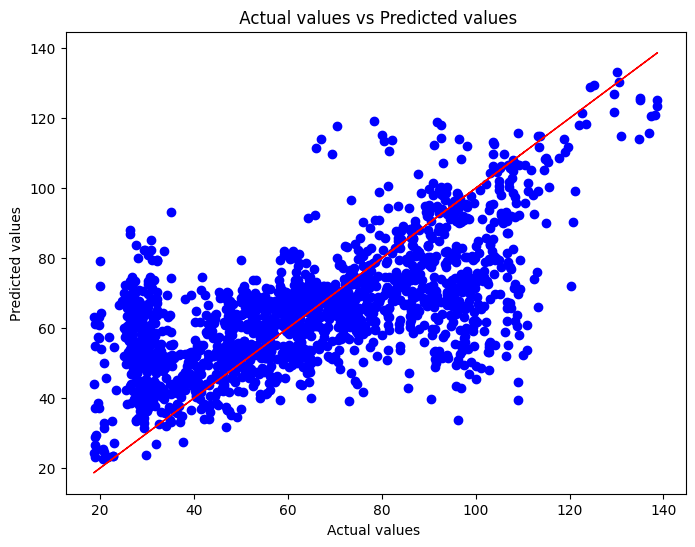

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, xgb_predictions, color='blue')
plt.plot(y_test, y_test, color='red', linestyle='-', linewidth=1)
plt.xlabel('Actual values ')
plt.ylabel('Predicted values')
plt.title(' Actual values vs Predicted values')
plt.show()

In [ ]:
# Calculate RMSE on test set
xgb_rmse = mean_squared_error(y_test, xgb_predictions, squared=False)
print(f"RMSE on test set: {xgb_rmse}")
xgb_r2 = r2_score(y_test, xgb_predictions)
print(f"R² = {xgb_r2:.2f}")

RMSE on test set: 19.83057167509378
R² = 0.44


In [ ]:
xgb_r2 = r2_score(y_test, xgb_predictions)
print(f"R² = {xgb_r2:.2f}")

R² = 0.44


# **LSTM model**

In [ ]:
tf.random.set_seed(42)


In [ ]:
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

In [ ]:
sequence_length = 30  # Using 30 days of data to predict the next day's price
X, y = create_sequences(data['PRICE'], sequence_length)

<ipython-input-45-81cf3d0688a0>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i + sequence_length])


In [ ]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
lstm = Sequential()
lstm.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm.add(LSTM(50))
lstm.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:

lstm.compile(optimizer='adam', loss='mean_squared_error')

Epoch 1/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 4112.8003 - val_loss: 3258.4275
Epoch 2/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2672.2522 - val_loss: 2419.9775
Epoch 3/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2019.4631 - val_loss: 1834.5479
Epoch 4/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1570.4976 - val_loss: 1408.8022
Epoch 5/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1257.3881 - val_loss: 1101.9889
Epoch 6/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1044.4551 - val_loss: 885.6436
Epoch 7/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 905.4497 - val_loss: 737.1421
Epoch 8/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 819.1827 - val_loss: 638.1124
Epoch 9/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 768.9181 - val_loss: 574.3984
Epoch 10/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 741.5480 - val_loss: 533.7667
Epoch 11/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 727.4522 - val_l

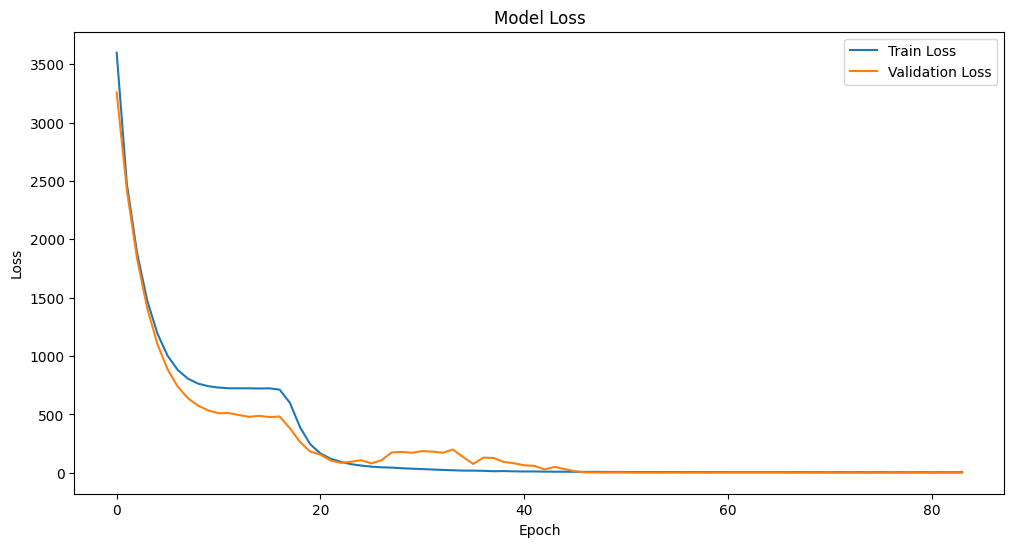

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = lstm.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
lstm_predictions = lstm.predict(X_test)

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [ ]:
resultsLSTM = pd.DataFrame({'actual prices': y_test, 'lstm_predictions': lstm_predictions.flatten()})
print(resultsLSTM)

      actual prices  lstm_predictions
0         77.706429         78.550117
1         77.605272         78.448029
2         77.458268         78.255562
3         77.271082         78.025612
4         77.045584         77.804543
...             ...               ...
1668      86.658100         87.661728
1669      86.581204         86.990532
1670      86.506870         86.311836
1671      86.448682         85.806717
1672      86.416841         85.594933

[1673 rows x 2 columns]


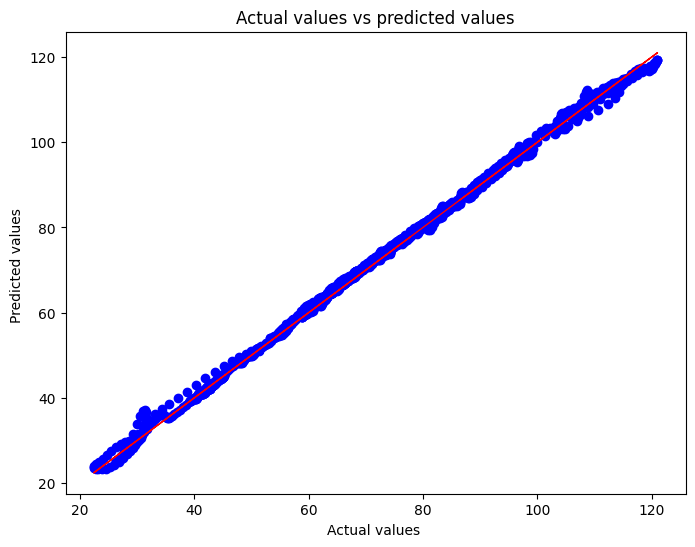

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, lstm_predictions, color='blue')
plt.plot(y_test, y_test, color='red', linestyle='-', linewidth=1)
plt.xlabel('Actual values ')
plt.ylabel('Predicted values ')
plt.title('Actual values vs predicted values')
plt.show()

In [ ]:
# Calculate RMSE on test set
lstm_rmse = mean_squared_error(y_test, lstm_predictions, squared=False)
print(f"RMSE on test set: {lstm_rmse}")

RMSE on test set: 0.9760994729733204


In [ ]:
from sklearn.metrics import r2_score
lstm_r2 = r2_score(y_test, lstm_predictions)
print(f"R² = {lstm_r2:.2f}")

R² = 1.00


# **CNN model**

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Dense
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
X = X.reshape(X.shape[0], X.shape[1], 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
cnn = Sequential()
cnn.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense(units=128, activation='relu'))
cnn.add(Dropout(rate=0.5))
cnn.add(Dense(units=1))

In [ ]:
cnn.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')  # or 'float32' if it's regression
y_test = y_test.astype('float32')

In [ ]:
cnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
210/210 [==============================] - 2s 6ms/step - loss: 208.5337 - val_loss: 11.4754
Epoch 2/50
210/210 [==============================] - 1s 5ms/step - loss: 155.2533 - val_loss: 24.1436
Epoch 3/50
210/210 [==============================] - 1s 5ms/step - loss: 151.7377 - val_loss: 8.1724
Epoch 4/50
210/210 [==============================] - 2s 8ms/step - loss: 148.2406 - val_loss: 9.0852
Epoch 5/50
210/210 [==============================] - 2s 9ms/step - loss: 148.9270 - val_loss: 24.3437
Epoch 6/50
210/210 [==============================] - 1s 6ms/step - loss: 136.9180 - val_loss: 45.4314
Epoch 7/50
210/210 [==============================] - 1s 5ms/step - loss: 134.3901 - val_loss: 6.4121
Epoch 8/50
210/210 [==============================] - 1s 5ms/step - loss: 139.2229 - val_loss: 5.0072
Epoch 9/50
210/210 [==============================] - 1s 5ms/step - loss: 133.0847 - val_loss: 8.6365
Epoch 10/50
210/210 [==============================] - 1s 5ms/step - loss: 124

53/53 [==============================] - 0s 2ms/step - loss: 2.3729
Test loss: 2.3728694915771484


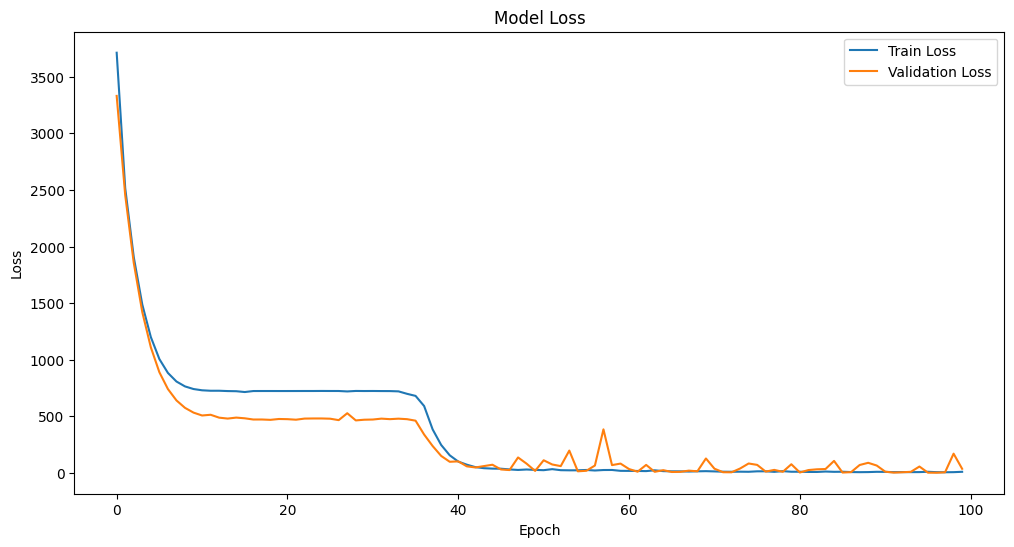

In [ ]:
loss = cnn.evaluate(X_test, y_test)
print('Test loss:', loss)
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
cnn_predictions = cnn.predict(X_test)

53/53 [==============================] - 0s 2ms/step


In [ ]:
resultsCNN = pd.DataFrame({'actual prices': y_test, 'cnn_predictions': cnn_predictions.flatten()})
print(resultsCNN)

      actual prices  cnn_predictions
0         94.699287       103.400185
1         65.138100        68.830444
2         38.852539        42.205139
3         46.560364        48.206787
4         64.242432        68.851143
...             ...              ...
1668      91.275772        92.365364
1669      88.688652        90.464439
1670     112.065720       115.391167
1671      18.977600        19.825407
1672      46.964287        48.567364

[1673 rows x 2 columns]


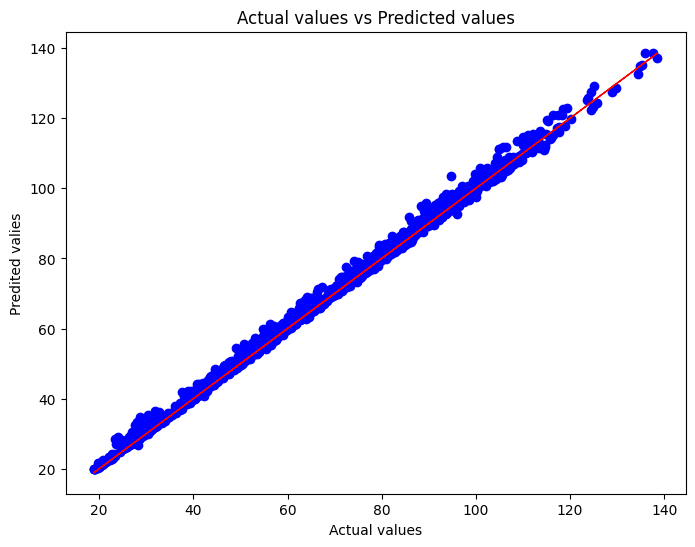

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, cnn_predictions, color='blue')
plt.plot(y_test, y_test, color='red', linestyle='-', linewidth=1)
plt.xlabel('Actual values')
plt.ylabel('Predited valies')
plt.title('Actual values vs Predicted values')
plt.show()

In [ ]:
# Calculate RMSE on test set
cnn_rmse = mean_squared_error(y_test, cnn_predictions, squared=False)
print(f"RMSE on test set: {cnn_rmse}")
cnn_r2 = r2_score(y_test, cnn_predictions)
print(f"R² = {cnn_r2:.2f}")

RMSE on test set: 1.5404120683670044
R² = 1.00


In [ ]:

cnn_r2 = r2_score(y_test, cnn_predictions)
print(f"R² = {cnn_r2:.2f}")

R² = 1.00


# Nouvelle section

# **Hybrid models**

# **1. LSTM-CNN model**

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Concatenate, Input
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras.models import Model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [ ]:
Oil_price = data['PRICE'].values.reshape(-1, 1)

# Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(Oil_price)

In [ ]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 10
X, y = create_dataset(scaled_prices, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define the LSTM-CNN hybrid model
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Concatenate
input_layer = Input(shape=(time_step, 1))

# CNN part
conv1 = Conv1D(filters=64, kernel_size=2, activation='relu')(input_layer)
maxpool1 = MaxPooling1D(pool_size=2)(conv1)
flatten = Flatten()(maxpool1)

# LSTM part
lstm = LSTM(50, return_sequences=True)(input_layer)
lstm = LSTM(50)(lstm)

# Concatenate CNN and LSTM parts
concat = Concatenate()([flatten, lstm])

# Fully connected layers
dense1 = Dense(50, activation='relu')(concat)
output = Dense(1)(dense1)

# Create the model
cnn_lstm = Model(inputs=input_layer, outputs=output)

# Compile the model
cnn_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
cnn_lstm.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 1)]              0         []                            
                                                                                                  
 conv1d_2 (Conv1D)           (None, 9, 64)                192       ['input_1[0][0]']             
                                                                                                  
 max_pooling1d_2 (MaxPoolin  (None, 4, 64)                0         ['conv1d_2[0][0]']            
 g1D)                                                                                             
                                                                                                  
 lstm_2 (LSTM)               (None, 10, 50)               10400     ['input_1[0][0]']         

In [ ]:
# Train the model
history = cnn_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
210/210 [==============================] - 9s 18ms/step - loss: 0.0048 - val_loss: 2.2661e-04
Epoch 2/50
210/210 [==============================] - 3s 14ms/step - loss: 2.1785e-04 - val_loss: 2.0843e-04
Epoch 3/50
210/210 [==============================] - 3s 13ms/step - loss: 2.1183e-04 - val_loss: 2.7702e-04
Epoch 4/50
210/210 [==============================] - 5s 22ms/step - loss: 1.8736e-04 - val_loss: 1.7236e-04
Epoch 5/50
210/210 [==============================] - 3s 14ms/step - loss: 1.6636e-04 - val_loss: 1.8312e-04
Epoch 6/50
210/210 [==============================] - 3s 13ms/step - loss: 1.3881e-04 - val_loss: 1.4348e-04
Epoch 7/50
210/210 [==============================] - 3s 14ms/step - loss: 1.1654e-04 - val_loss: 9.5699e-05
Epoch 8/50
210/210 [==============================] - 4s 17ms/step - loss: 1.1134e-04 - val_loss: 1.3165e-04
Epoch 9/50
210/210 [==============================] - 4s 18ms/step - loss: 7.7835e-05 - val_loss: 5.5467e-05
Epoch 10/50
210/210 [==

In [ ]:
# Evaluate the model
train_loss = cnn_lstm.evaluate(X_train, y_train, verbose=0)
test_loss = cnn_lstm.evaluate(X_test, y_test, verbose=0)
print(f'Train Loss: {train_loss}, Test Loss: {test_loss}')


Train Loss: 3.0439066449616803e-06, Test Loss: 2.904053644670057e-06


In [ ]:
# Make predictions
cnn_lstm_predictions = cnn_lstm.predict(X_test)

# Inverse transform the predictions to get the actual prices
cnn_lstm_predictions = scaler.inverse_transform(cnn_lstm_predictions)

y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

53/53 [==============================] - 1s 4ms/step


In [ ]:

# Ensure y_test and cnn_lstm_predictions are numpy arrays
y_test = np.array(y_test)
cnn_lstm_predictions = np.array(cnn_lstm_predictions)

# Check the shape of y_test and cnn_lstm_predictions
print("Shape of y_test:", y_test.shape)
print("Shape of cnn_lstm_predictions:", cnn_lstm_predictions.shape)

Shape of y_test: (1677, 1)
Shape of cnn_lstm_predictions: (1677, 1)


In [ ]:
if y_test.ndim > 1:
    y_test = y_test.reshape(-1)

if cnn_lstm_predictions.ndim > 1:
    cnn_lstm_predictions = cnn_lstm_predictions.reshape(-1)

In [ ]:
resultsCNNlstm = pd.DataFrame({'actual prices': y_test, 'cnn lstm predictions': cnn_lstm_predictions})
print(resultsCNNlstm)


      actual prices  cnn lstm predictions
0         94.962974             94.776138
1        107.981214            108.190453
2         48.530286             48.637257
3         95.626969             95.834312
4         60.090281             59.713505
...             ...                   ...
1672      35.962855             35.943306
1673      61.824139             62.027866
1674      52.135276             52.207817
1675      49.358847             49.307117
1676     115.551182            115.901237

[1677 rows x 2 columns]


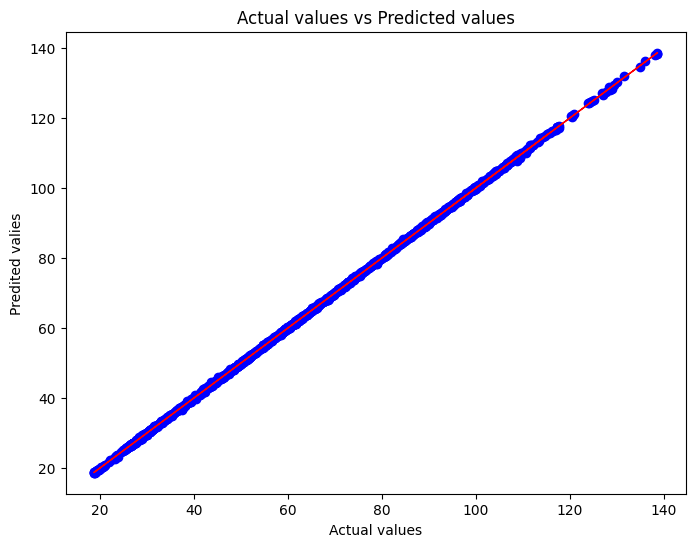

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, cnn_lstm_predictions, color='blue')
plt.plot(y_test, y_test, color='red', linestyle='-', linewidth=1)
plt.xlabel('Actual values')
plt.ylabel('Predited valies')
plt.title('Actual values vs Predicted values')
plt.show()

In [ ]:
# Calculate RMSE on test set
cnn_lstm_rmse = mean_squared_error(y_test, cnn_lstm_predictions, squared=False)
print(f"RMSE on test set: {cnn_lstm_rmse}")

RMSE on test set: 0.20457619347427294


In [ ]:
cnn_lstm_r2 = r2_score(y_test, cnn_lstm_predictions)
print(f"R² = {cnn_lstm_r2:.2f}")

R² = 1.00


# **2. RF-XGBoost model**

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

# Train individual models
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

xgb = XGBRegressor()
xgb.fit(X_train, y_train)

# Combine predictions from individual models
X_train_hybrid = np.column_stack((rf.predict(X_train), xgb.predict(X_train)))
X_test_hybrid = np.column_stack((rf.predict(X_test), xgb.predict(X_test)))

# Train hybrid model using Linear Regression
rf_xgb = LinearRegression()
rf_xgb.fit(X_train_hybrid, y_train)


ValueError: Found array with dim 3. RandomForestRegressor expected <= 2.

In [ ]:
# Evaluate hybrid model on test set
rf_xgb_predictions = rf_xgb.predict(X_test_hybrid)
resultsrf_xgb = pd.DataFrame({'actual prices': y_test, 'rf_xgb_predictions': rf_xgb_predictions.flatten()})
print(resultsrf_xgb)

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, rf_xgb_predictions, color='blue')
plt.plot(y_test, y_test, color='red', linestyle='-', linewidth=1)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual values vs predicted values')
plt.show()

In [ ]:
rf_xgb_rmse = mean_squared_error(y_test, rf_xgb_predictions, squared=False)
print(f"RMSE on test set: {rf_xgb_rmse}")
rf_xgb_r2 = r2_score(y_test, rf_xgb_predictions)
print(f"R² = {rf_xgb_r2:.2f}")

# **3. RandomForest-XGBoost model**

In [ ]:
# Calculate RMSE and R2
rf_xgb_rmse = np.sqrt(mean_squared_error(y_test, rf_xgb_predictions))
rf_xgb_r2 = r2_score(y_test, rf_xgb_predictions)
print(f"RMSE: {rf_xgb_rmse:.2f}")
print(f"R2: {rf_xgb_r2:.2f}")

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, rf_xgb_predictions, color='blue')
plt.plot(y_test, y_test, color='red', linestyle='-', linewidth=1)
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Valeurs prédites vs Valeurs réelles')
plt.show()

# **LSTM2**

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Convert the data to a numpy array
data = data.values

# Scale the data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[0:train_size], data[train_size:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(data.shape[1], 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(train_data, epochs=100, batch_size=32, verbose=2)

# Make predictions on the test data
predictions = model.predict(test_data)

# Convert the predictions back to the original scale
predictions = scaler.inverse_transform(predictions)

# Plot the actual and predicted values
import matplotlib.pyplot as plt
plt.plot(test_data)
plt.plot(predictions)
plt.show()

In [ ]:
import numpy as np

# Set a random seed
np.random.seed(42)

In [ ]:
X_train = X_train.reshape(-1, 1, X_train.shape[1])

In [ ]:
model = Sequential()
model.add(LSTM(50))
model.add(Dense(1))
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

model.add(Activation('linear'))

In [ ]:
algorithm = ADAM(lr=0.1)
model.compile(optimizer=algorithm, loss='mean_squared_error')

In [ ]:
history = model.fit(X, y, batch_size=10, epochs=100)

In [ ]:
loss, accuracy = model.evaluate(X, y)

In [ ]:
predictions = model.predict(X)

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))

In [ ]:
model = Sequential()
model.add(LSTM(5, input_shape=(2,1)))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# **COMPARISON**

In [ ]:
# Create a list of your predictions
predictions = [svr_predictions, rf_predictions, xgb_predictions, cnn_predictions, lstm_predictions, cnn_lstm_predictions, rf_xgb_predictions]

# Create a list of model names or labels
model_names = ['SVR', 'RF', 'XGB', 'CNN', 'LSTM', 'CNN-LSTM', 'RF-XGB']

# Calculate the R-squared and RMSE values for each model
r_squared_values = [r2_score(y_test, y_pred) for y_pred in predictions]
rmse_values = [np.sqrt(mean_squared_error(y_test, y_pred)) for y_pred in predictions]

# Create the figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the R-squared values
ax1.bar(model_names, r_squared_values)
ax1.set_title('Comparison of Regression Models')
ax1.set_xlabel('Model')
ax1.set_ylabel('R-squared')
ax1.tick_params(axis='x', rotation=45)

# Create a twin axis for the RMSE values
ax2 = ax1.twinx()

# Plot the RMSE values
ax2.plot(model_names, rmse_values, marker='o', color='r')
ax2.set_ylabel('RMSE', color='r')
ax2.tick_params('y', colors='r')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()